In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/allstate-claims-severity/sample_submission.csv
/kaggle/input/allstate-claims-severity/train.csv.zip
/kaggle/input/allstate-claims-severity/sample_submission.csv.zip
/kaggle/input/allstate-claims-severity/train.csv
/kaggle/input/allstate-claims-severity/test.csv
/kaggle/input/allstate-claims-severity/test.csv.zip


In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
from subprocess import check_output
from scipy.stats import norm, lognorm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

In [3]:
# Read Data
train  = pd.read_csv("../input/allstate-claims-severity/train.csv")
test = pd.read_csv("../input/allstate-claims-severity/test.csv")

In [4]:
features = [x for x in train.columns if x not in ['id','loss']]
cat_features = [x for x in train.select_dtypes(include=['object']).columns if x not in ['id','loss']]
cont_features = [x for x in train.select_dtypes(exclude=['object']).columns if x not in ['id','loss']]

In [5]:
# log-normal distribution
train['log_loss'] = np.log(train['loss'])

# fit the normal distribution on ln(loss)
(mu,sigma) = norm.fit(train['log_loss'])

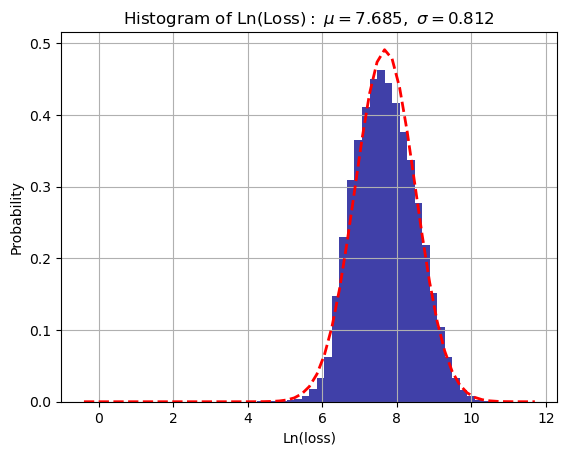

In [6]:
# the histogram of the ln(loss)
n, bins, patches = plt.hist(train['log_loss'], 60, density=1, facecolor='darkblue', alpha=0.75,stacked=True)

# Add the fitted line 
y = norm.pdf(bins, mu, sigma)
x = plt.plot(bins,y,'r--',linewidth=2)

# label
plt.xlabel('Ln(loss)')
plt.ylabel('Probability')
plt.title(r'$\mathrm{Histogram\ of\ Ln(Loss):}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
plt.grid(True)
plt.show()


In [7]:
ntrain = train.shape[0]
ntest = test.shape[0]
train_test = pd.concat((train[features], test[features])).reset_index(drop=True)
for c in range(len(cat_features)):
    train_test[cat_features[c]] = train_test[cat_features[c]].astype('category').cat.codes

train_x = train_test.iloc[:ntrain,:]
test_x = train_test.iloc[ntrain:,:]

In [8]:
xgdmat = xgb.DMatrix(train_x, train['log_loss']) # Create our DMatrix to make XGBoost more efficient

params = {'eta': 0.01, 'seed':0, 'subsample': 0.5, 'colsample_bytree': 0.5, 
             'objective': 'reg:linear', 'max_depth':6, 'min_child_weight':3} 

# Grid Search CV optimized settings
num_rounds = 1000
bst = xgb.train(params, xgdmat, num_boost_round = num_rounds)


[19:02:12] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


,feature,fscore
0,cat20,0.000037
1,cat48,0.000037
2,cat69,0.000055
3,cat68,0.000073
4,cat35,0.000091
...,...,...
121,cont3,0.026335
122,cont2,0.039302
123,cat100,0.052287
124,cont7,0.056068


<Figure size 640x480 with 0 Axes>

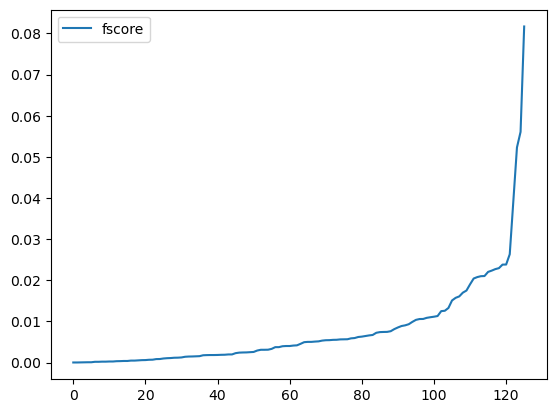

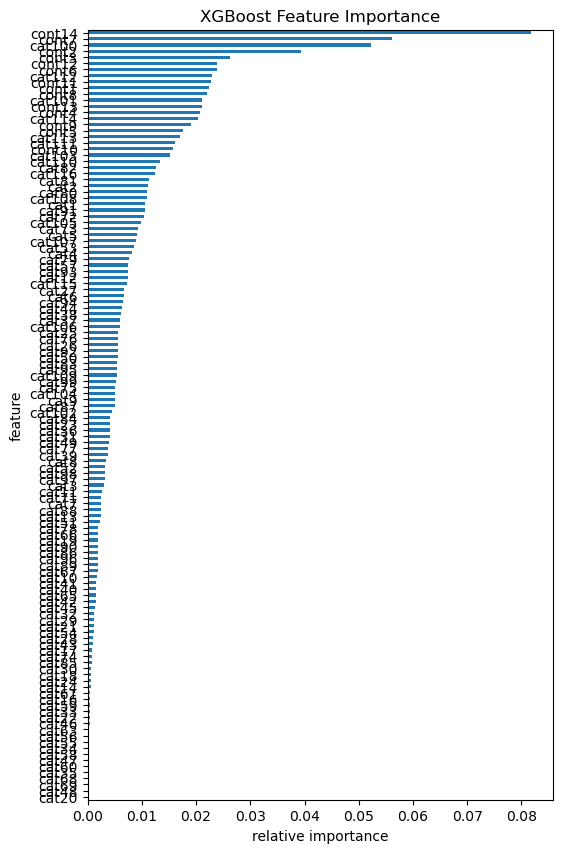

In [9]:
import operator

def ceate_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1

    outfile.close()
    
ceate_feature_map(features)

importance = bst.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

plt.figure()
df.plot()
df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.gcf().savefig('feature_importance_xgb.png')

df

In [14]:
test_xgb = xgb.DMatrix(test_x)
submission = pd.read_csv("../input/allstate-claims-severity/sample_submission.csv")
submission.iloc[:, 1] = np.exp(bst.predict(test_xgb))
submission.to_csv('Result.csv', index=None)